# Time Series Extrinsic Regression (TSER) with aeon

Time Series Regression (TSR) involves training a model from a collection of time
series (real valued, ordered, data) in order to predict a continuous target variable.

There are two types of TSR.

1) Time Series Forecasting Regression (TSFR) relates to forecasting reduced to regression
through a sliding window. This is the more familiar type to most people. The notebook
for forecasting using supervised regressors can be found [here](../forecasting/forecasting_sklearn.ipynb).

2) Time Series *Extrinsic* Regression (TSER) was formally specified in Tan et al. [1] as a
related, but distinct, type of time series regression problem. Rather than being derived from a
forecasting problem, TSER involves a predictive model built on time series to predict a real-valued
variable distinct from the training input series.

This notebook focuses on the `aeon` regression module, which consists of algorithms for TSER.

<img src="img/tser.png" width="600" alt="time series regression">

An example TSER problem is shown in the below image of soil spectrograms which can be used to estimate
the potassium concentration. Ground truth is found through expensive
lab based experiments that take some time. Spectrograms (ordered data series we treat as time series)
are cheap to obtain and the data can be collected in any environment. An accurate regressor from spectrogram
to concentration would make land and crop management more efficient.

<img src="img/spectra.png" width="600" alt="spectrograph example">

## Data Storage and Problem Types

Regressors take time series input as either 3D numpy of shape`(n_cases, n_channels, n_timepoints)` for
equal length series or as a list of 2D numpy of length `[n_cases]`. All regressors work with equal
length problems. Regression functionality for unequal length is currently limited.

`aeon` ships two example regression problems in the `datasets` module:

In [9]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from aeon.datasets import load_cardano_sentiment, load_covid_3month

warnings.filterwarnings("ignore")

covid_train, covid_train_y = load_covid_3month(split="train")
covid_test, covid_test_y = load_covid_3month(split="test")
cardano_train, cardano_train_y = load_cardano_sentiment(split="train")
cardano_test, cardano_test_y = load_cardano_sentiment(split="test")
covid_train.shape

(140, 1, 84)

Covid3Month is from the [monash tser archive](http://tseregression.org/) who in turn got
the data from [WHO's COVID-19 database](https://covid19.who.int/). The goal of this dataset is to predict
COVID-19's death rate on 1st April 2020 for each country using daily confirmed cases for the last three months.

This dataset contains 201 time series (140 train, 61 test), where each time series is
the daily confirmed cases for a country. The data is univariate, each series length 84.

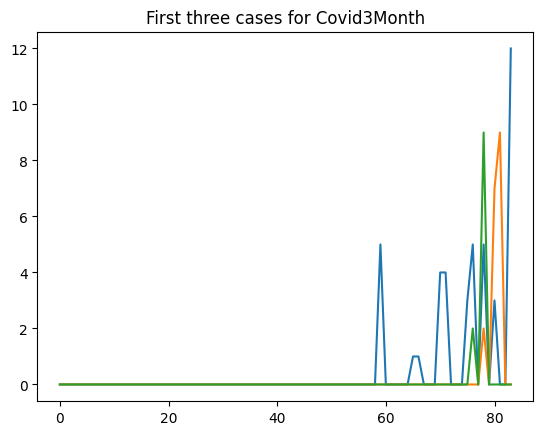

In [10]:
plt.title("First three cases for Covid3Month")
plt.plot(covid_train[0][0])
plt.plot(covid_train[1][0])
plt.plot(covid_train[2][0])

In [11]:
cardano_train.shape

(74, 2, 24)

The CardanoSentiment dataset was created By combining historical sentiment data for
Cardano cryptocurrency, extracted from EODHistoricalData and made available on
Kaggle, with historical price data for the same cryptocurrency extracted from
CryptoDataDownload. The predictors are hourly close price (in USD) and traded
volume during a day, resulting in 2-dimensional time series of length 24. The
response variable is the normalized sentiment score on the day spanned by the timepoints.

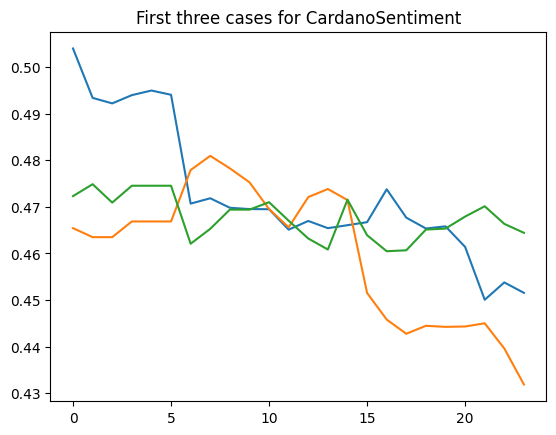

In [12]:
plt.title("First three cases for CardanoSentiment")
plt.plot(cardano_train[0][0])
plt.plot(cardano_train[1][0])
plt.plot(cardano_train[2][0])

# Time Series Regressors in aeon

All regressors inherit from the `BaseRegressor` class. Like classification and
clustering, regressors have methods `fit` and `predict` to train and use the model.
The list of regressors available can be found with `all_estimators`.

In [13]:
from aeon.registry import all_estimators

all_estimators("regressor", as_dataframe=True)

,name,estimator
0,CNNRegressor,<class 'aeon.regression.deep_learning.cnn.CNNR...
1,CanonicalIntervalForestRegressor,<class 'aeon.regression.interval_based._cif.Ca...
2,Catch22Regressor,<class 'aeon.regression.feature_based._catch22...
3,DrCIFRegressor,<class 'aeon.regression.interval_based._drcif....
4,DummyRegressor,<class 'aeon.regression._dummy.DummyRegressor'>
5,FCNRegressor,<class 'aeon.regression.deep_learning.fcn.FCNR...
6,FreshPRINCERegressor,<class 'aeon.regression.feature_based._fresh_p...
7,InceptionTimeRegressor,<class 'aeon.regression.deep_learning.inceptio...
8,IndividualInceptionRegressor,<class 'aeon.regression.deep_learning.inceptio...
9,IntervalForestRegressor,<class 'aeon.regression.interval_based._interv...


Currently we have 18 regressors, including deep learning, feature based, convolution
based, interval based and distance based regressors, in addition to the utility
regressors such as Dummy and Pipeline.

In [14]:
from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor

knn = KNeighborsTimeSeriesRegressor()
knn.fit(covid_train, covid_train_y)
p = knn.predict(covid_test)
sse = np.sum((covid_test_y - p) * (covid_test_y - p))
sse

0.17823940618016532

## Multivariate Regression
Nearly all of the regressors can handle multivariate data

In [15]:
all_estimators(
    "regressor", filter_tags={"capability:multivariate": True}, as_dataframe=True
)

,name,estimator
0,CNNRegressor,<class 'aeon.regression.deep_learning.cnn.CNNR...
1,CanonicalIntervalForestRegressor,<class 'aeon.regression.interval_based._cif.Ca...
2,Catch22Regressor,<class 'aeon.regression.feature_based._catch22...
3,DrCIFRegressor,<class 'aeon.regression.interval_based._drcif....
4,DummyRegressor,<class 'aeon.regression._dummy.DummyRegressor'>
5,FCNRegressor,<class 'aeon.regression.deep_learning.fcn.FCNR...
6,FreshPRINCERegressor,<class 'aeon.regression.feature_based._fresh_p...
7,InceptionTimeRegressor,<class 'aeon.regression.deep_learning.inceptio...
8,IndividualInceptionRegressor,<class 'aeon.regression.deep_learning.inceptio...
9,IntervalForestRegressor,<class 'aeon.regression.interval_based._interv...


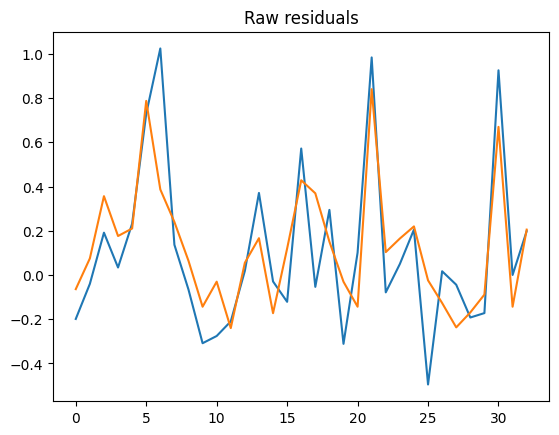

In [16]:
from aeon.regression import DummyRegressor

fp = KNeighborsTimeSeriesRegressor()
dummy = DummyRegressor()
dummy.fit(cardano_train, cardano_train_y)
knn.fit(cardano_train, cardano_train_y)
pred = knn.predict(cardano_test)
res_knn = cardano_test_y - pred
res_dummy = cardano_test_y - dummy.predict(cardano_test)
plt.title("Raw residuals")
plt.plot(res_knn)
plt.plot(res_dummy)

## References

[1] Tan et al. "Time series extrinsic regression", Data Mining and Knowledge
Discovery, 35(3), 2021
[2] Guijo-Rubio et al. "Unsupervised Feature Based Algorithms for Time Series
Extrinsic Regression", ArXiv, 2023